In [28]:
! pip install konlpy > /dev/null

# 네이버 영화평 분석 - LSTM

In [3]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## 1.데이터 전처리

In [4]:
train_df = pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt', sep = '\t')
test_df = pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt', sep = '\t')

In [5]:
print(train_df.shape, test_df.shape)
train_df.head(3)

(150000, 3) (50000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [6]:
train_df.isna().sum()

id          0
document    5
label       0
dtype: int64

In [7]:
train_df.dropna(how = 'any', inplace = True)
train_df.shape

(149995, 3)

In [8]:
# 중복 데이터 확인
train_df.document.nunique()

146182

In [9]:
# 중복 데이터 제거
train_df.drop_duplicates(subset = ['document'], inplace = True)
train_df.shape

(146182, 3)

In [10]:
# 긍부정 개수 확인
train_df.label.value_counts()

0    73342
1    72840
Name: label, dtype: int64

In [11]:
test_df.isna().sum()

id          0
document    3
label       0
dtype: int64

In [12]:
test_df.dropna(how = 'any', inplace = True)
test_df.shape

(49997, 3)

In [17]:
test_df.isna().sum().sum()

0

In [13]:
test_df.document.nunique()

49157

In [14]:
# document 중복 제거
test_df.drop_duplicates(subset = ['document'], inplace = True)

In [15]:
test_df.shape

(49157, 3)

In [16]:
test_df.label.value_counts()

1    24711
0    24446
Name: label, dtype: int64

## 2.Document 데이터 한글 전처리

In [18]:
# 한글 이외 글자 공백으로
# strip([chars]) : 인자로 전달된 문자를 String의 왼쪽과 오른쪽에서 제거합니다.
train_df.document = train_df.document.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]', ' ').str.strip()
train_df.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [19]:
# ''만 남은 데이터 -> np.nan으로 대체 후 제거
train_df.document.replace('', np.nan, inplace = True)
train_df.document.isna().sum()

789

In [20]:
train_df.dropna(how = 'any', inplace = True)
train_df.shape

(145393, 3)

- test

In [21]:
test_df.document = test_df.document.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]', ' ').str.strip()
test_df.document.replace('', np.nan, inplace = True)
test_df.dropna(how = 'any', inplace = True)
test_df.shape

(48852, 3)

## 3.한글처리

In [29]:
from konlpy.tag import Okt
okt = Okt()

In [32]:
stopwords = ['이','가','의','은','들','는','좀','잘','걍',
             '과','도','를','으로','자','에','와','한','하다','을','ㅋ']

In [34]:
from tqdm import tqdm

X_train = []
for sentence in tqdm(train_df.document):
    morphs = okt.morphs(sentence, stem = True)
    tmp_X =  [word for word in morphs if word not in stopwords]
    X_train.append(tmp_X)

100%|██████████| 145393/145393 [08:28<00:00, 286.20it/s]


In [36]:
X_train[:3]

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]

In [ ]:
X_test = []
for sentence in tqdm(test_df.document):
    morphs = okt.morphs(sentence, stem = True)
    tmp_str =  ' '.join([word for word in okt.morphs(text, stem = True) if word not in stopwords])
    X_test.append(tmp_str)

100%|██████████| 48852/48852 [02:40<00:00, 303.56it/s]


In [ ]:
y_train = train_df.label.values
y_test = test_df.label.values

## 4.Keras Tokenizer -> train_test_split
- 시간관계상 train에서 train/test split 진행

In [35]:
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [37]:
from tensorflow.keras.preprocessing.text import Tokenizer
token = Tokenizer()
token.fit_on_texts(X_train)

In [38]:
len(token.word_index)

43120

In [42]:
# 빈도수 상위 2만개 데이터로 인코딩
num_words = 20000
token = Tokenizer(num_words=num_words)
token.fit_on_texts(X_train)
len(token.word_index)

43120

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_train, train_df.label.values, test_size = 0.2, stratify = train_df.label.values,
    random_state = seed 
)

In [44]:
X_train = token.texts_to_sequences(X_train)
X_test = token.texts_to_sequences(X_test)

In [46]:
# 데이터 최대 길이 / 평균 길이
max_len = max(len(s) for s in X_train)
max_len, sum(map(len, X_train)) / len(X_train)

(70, 10.632357239885138)

In [47]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 40
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
X_train.shape, X_test.shape

((116314, 40), (29079, 40))

## 5.LSTM 모델 정의 및 설정, 학습 - 84.5

In [48]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [49]:
model = Sequential([
    Embedding(num_words, 120, input_length=max_len),
    LSTM(128),
    Dense(1, activation = 'sigmoid')
])

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 120)           2400000   
                                                                 
 lstm (LSTM)                 (None, 128)               127488    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,527,617
Trainable params: 2,527,617
Non-trainable params: 0
_________________________________________________________________


In [52]:
model.compile('adam', 'binary_crossentropy', ['accuracy'])
model_path = 'best-naver-movie-lstm.h5'
mc = ModelCheckpoint(model_path, save_best_only=True, verbose = 1)
es = EarlyStopping(patience=5)
hist = model.fit(X_train, y_train, validation_split = 0.2,
                 epochs = 30, batch_size = 128, callbacks = [mc, es])

Epoch 1/30
727/727 [==============================] - ETA: 0s - loss: 0.3996 - accuracy: 0.8164
Epoch 1: val_loss improved from inf to 0.36112, saving model to best-naver-movie-lstm.h5
727/727 [==============================] - 177s 234ms/step - loss: 0.3996 - accuracy: 0.8164 - val_loss: 0.3611 - val_accuracy: 0.8388
Epoch 2/30
727/727 [==============================] - ETA: 0s - loss: 0.3067 - accuracy: 0.8692
Epoch 2: val_loss improved from 0.36112 to 0.35375, saving model to best-naver-movie-lstm.h5
727/727 [==============================] - 140s 193ms/step - loss: 0.3067 - accuracy: 0.8692 - val_loss: 0.3537 - val_accuracy: 0.8449
Epoch 3/30
727/727 [==============================] - ETA: 0s - loss: 0.2542 - accuracy: 0.8942
Epoch 3: val_loss did not improve from 0.35375
727/727 [==============================] - 137s 189ms/step - loss: 0.2542 - accuracy: 0.8942 - val_loss: 0.3694 - val_accuracy: 0.8440
Epoch 4/30
727/727 [==============================] - ETA: 0s - loss: 0.2114 -

In [54]:
best_model = load_model(model_path)
best_model.evaluate(X_test, y_test)

909/909 [==============================] - 23s 23ms/step - loss: 0.3516 - accuracy: 0.8458


[0.35156282782554626, 0.8457649946212769]

## 6.실제 데이터 예측

In [57]:
text = '아 진짜 이렇게 흥미진진할 수 있는거임?'
import re
text = re.sub('[^ㄱ-ㅎ가-힣]', ' ', text).strip()
morphs = okt.morphs(text, stem = True)
text = [w for w in morphs if w not in stopwords]
encoded = token.texts_to_sequences([text])
encoded

[[46, 15, 95, 863, 66, 5, 105]]

In [65]:
padded = pad_sequences(encoded, maxlen = max_len)
score = best_model.predict(padded)[0,0]
print('긍정' if score > 0.5 else '부정')

긍정


In [66]:
def sentiment_predict(text, tokenizer = token, max_len = max_len):
    text = re.sub('[^ㄱ-ㅎ가-힣]', ' ', text).strip()
    morphs = okt.morphs(text, stem = True)
    text = [w for w in morphs if w not in stopwords]
    encoded = token.texts_to_sequences([text])
    padded = pad_sequences(encoded, maxlen = max_len)
    score = best_model.predict(padded)[0,0]
    return '긍정' if score > 0.5 else '부정'

In [67]:
sentiment_predict('시간 아까워')

'부정'

## 7.학습과정 시각화

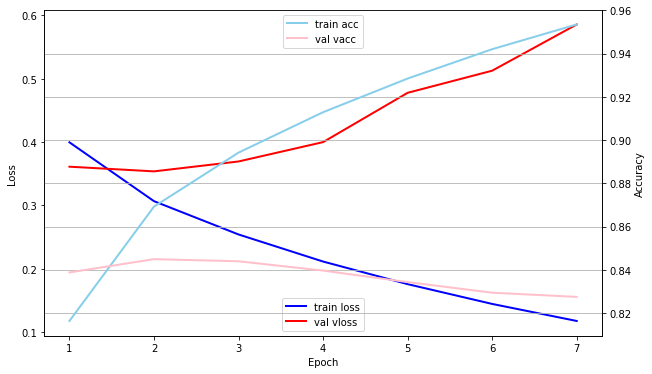

In [76]:
import matplotlib.pyplot as plt

y_acc = hist.history['accuracy']
y_loss = hist.history['loss']
y_vacc = hist.history['val_accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

# X축 공유
# y축 좌 : loss / 우 : acc
# plt.subplots 사용

fig, ax0 = plt.subplots(figsize = (10, 6))
ax1 = ax0.twinx()
ax0.plot(xs, y_loss, c = 'blue',lw = 2,label = 'train loss')
ax0.plot(xs, y_vloss, c ='red',lw = 2,label = 'val vloss')
ax0.set_ylabel('Loss')
ax0.set_xlabel('Epoch')
ax1.plot(xs, y_acc, lw = 2,c = 'skyblue',label = 'train acc')
ax1.plot(xs, y_vacc, lw = 2,c='pink',label = 'val vacc')
ax1.set_ylabel('Accuracy')
ax0.legend(loc = 'lower center')
ax1.legend(loc = 'upper center')
plt.grid()
plt.show()

## 8.Conv1D + GRU - 84.5

In [77]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

In [80]:
model2 = Sequential([
    Embedding(num_words, 120, input_length=max_len),
    Dropout(0.5),
    Conv1D(64, 5, activation = 'relu'),
    MaxPooling1D(5),
    GRU(128),
    Dense(1, activation='sigmoid')
])
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 40, 120)           2400000   
                                                                 
 dropout_2 (Dropout)         (None, 40, 120)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 36, 64)            38464     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 7, 64)            0         
 1D)                                                             
                                                                 
 gru (GRU)                   (None, 128)               74496     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                      

In [81]:
model2.compile('adam', 'binary_crossentropy', ['accuracy'])

model_path2 = 'best-naver-movie-Conv1d_v2.h5'
mc2 = ModelCheckpoint(model_path2, verbose=1, save_best_only=True)
es2 = EarlyStopping(patience=2)

hist2 = model2.fit(X_train, y_train, validation_split = 0.2,
                 epochs = 30, batch_size =128, callbacks = [mc2, es2])

Epoch 1/30
727/727 [==============================] - ETA: 0s - loss: 0.4586 - accuracy: 0.7720
Epoch 1: val_loss improved from inf to 0.40795, saving model to best-naver-movie-Conv1d_v2.h5
727/727 [==============================] - 73s 93ms/step - loss: 0.4586 - accuracy: 0.7720 - val_loss: 0.4079 - val_accuracy: 0.8079
Epoch 2/30
727/727 [==============================] - ETA: 0s - loss: 0.3643 - accuracy: 0.8344
Epoch 2: val_loss did not improve from 0.40795
727/727 [==============================] - 67s 92ms/step - loss: 0.3643 - accuracy: 0.8344 - val_loss: 0.4098 - val_accuracy: 0.8096
Epoch 3/30
727/727 [==============================] - ETA: 0s - loss: 0.3112 - accuracy: 0.8617
Epoch 3: val_loss did not improve from 0.40795
727/727 [==============================] - 87s 120ms/step - loss: 0.3112 - accuracy: 0.8617 - val_loss: 0.4276 - val_accuracy: 0.8062


In [82]:
best_model2 = load_model(model_path)
best_model2.evaluate(X_test, y_test)

909/909 [==============================] - 16s 18ms/step - loss: 0.3516 - accuracy: 0.8458


[0.35156282782554626, 0.8457649946212769]